<a href="https://colab.research.google.com/github/Tushaam/ISRO-NeRF/blob/main/ISRO_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
print(os.getcwd())

/content


In [33]:
data_path = '/content/drive/My Drive/ISRO'
print(os.listdir(data_path))
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

['test', 'val', 'train']


In [34]:
print(train_dir)
print(os.listdir())

/content/drive/My Drive/ISRO/train
['.config', 'drive', 'sample_data']


Now we will try to convert all images to jpeg format

In [35]:

from PIL import Image
import os

def convert_format(input_dir):
    for filename in os.listdir(input_dir):
        if filename.endswith(".png"):
            img_path = os.path.join(input_dir, filename)
            prefix = filename.split(".png")[0]
            img = Image.open(img_path)
            img.save(os.path.join(input_dir, prefix + '.jpeg'))
            img.close()
            os.remove(img_path)
        else:
            continue

print("Successfully converted to JPEG!!")

convert_format(train_dir)
convert_format(val_dir)
convert_format(test_dir)


Successfully converted to JPEG!!


In [50]:
def resize_images(input_dir, size):
    for filename in os.listdir(input_dir):
        img_path=os.path.join(input_dir,filename)
        img=Image.open(img_path)
        resized_img = img.resize(size, Image.LANCZOS)
        resized_img.save(img_path)
        img.close()

size=(256,256)
resize_images(train_dir,size)
resize_images(val_dir,size)
resize_images(test_dir,size)

In [37]:

def count_imgs(input_dir):
    count=0
    for image in os.listdir(input_dir):
        if image.endswith(".jpeg"):
            count+=1
    print(f"Total images in {input_dir} are:{count}")

count_imgs(train_dir)
count_imgs(val_dir)
count_imgs(test_dir)


Total images in /content/drive/My Drive/ISRO/train are:60
Total images in /content/drive/My Drive/ISRO/val are:10
Total images in /content/drive/My Drive/ISRO/test are:20


We had done the above check to verify if the images are correctly accessible by python

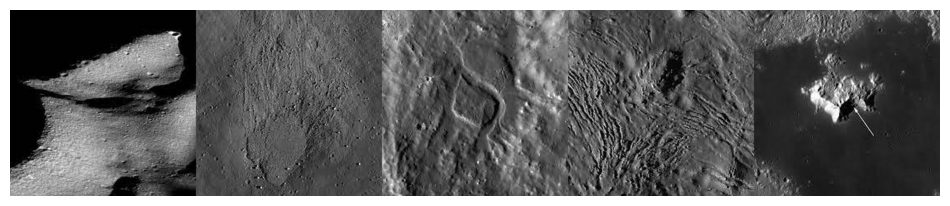

In [40]:
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

image_files = glob.glob('/content/drive/My Drive/ISRO/train/*.jpeg')

random.shuffle(image_files)


images = [cv2.imread(file) for file in image_files[:5]]

stacked_image = np.hstack(images)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(stacked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



We will start with the NeRF model implementation now

In [51]:
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten

#NeRF Architecture:

def nerf():
    model=Sequential([
        Dense(256, activation='relu',input_shape=(256,256,3)),
        Dense(128, activation='relu'),
        Dense(64,  activation='relu'),
        Dense(32,  activation='relu'),
        Dense(3)
    ])
    return model

model=nerf()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256, 256, 256)     1024      
                                                                 
 dense_6 (Dense)             (None, 256, 256, 128)     32896     
                                                                 
 dense_7 (Dense)             (None, 256, 256, 64)      8256      
                                                                 
 dense_8 (Dense)             (None, 256, 256, 32)      2080      
                                                                 
 dense_9 (Dense)             (None, 256, 256, 3)       99        
                                                                 
Total params: 44355 (173.26 KB)
Trainable params: 44355 (173.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


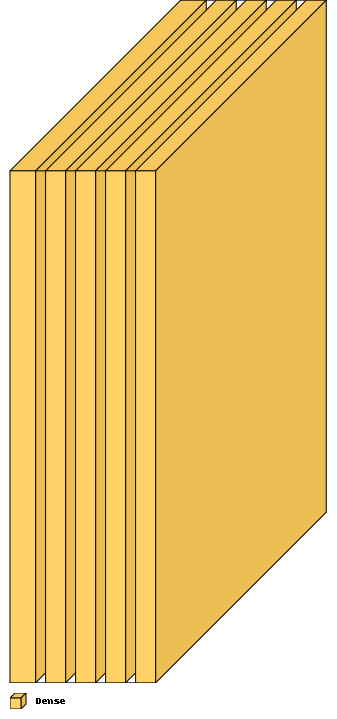

In [52]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model,scale_xy=2,legend=True)

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpeg"):
            img = load_img(os.path.join(directory, filename))
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)

x_train = load_images_from_dir(train_dir)
x_val = load_images_from_dir(val_dir)

x_train = x_train / 255.0
x_val = x_val / 255.0

y_train = np.arange(len(x_train))
y_val = np.arange(len(x_val))

print(f"Number of training images: {len(x_train)}")
print(f"Number of validation images: {len(x_val)}")

Number of training images: 60
Number of validation images: 10


In [54]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [59]:
history=model.fit(x_train,x_train,epochs=5,batch_size=16,validation_data=(x_val,x_val))

Epoch 1/5
4/4 [==============================] - 1s 283ms/step - loss: 0.0028 - mae: 0.0431 - val_loss: 0.0035 - val_mae: 0.0469
Epoch 2/5
4/4 [==============================] - 1s 260ms/step - loss: 0.0046 - mae: 0.0528 - val_loss: 0.0019 - val_mae: 0.0349
Epoch 3/5
4/4 [==============================] - 1s 256ms/step - loss: 0.0016 - mae: 0.0319 - val_loss: 0.0014 - val_mae: 0.0331
Epoch 4/5
4/4 [==============================] - 1s 261ms/step - loss: 0.0012 - mae: 0.0307 - val_loss: 9.8410e-04 - val_mae: 0.0288
Epoch 5/5
4/4 [==============================] - 1s 256ms/step - loss: 6.6079e-04 - mae: 0.0216 - val_loss: 3.5649e-04 - val_mae: 0.0149


In [60]:
loss=[0.1284,0.0562,0.0147,0.0088,0.0088]
mae=[0.3093,0.1976,0.0917,0.0820,0.0871]

print("Average loss after training for 5 epochs:",np.mean(loss).round(4))
print("Average MAE after training for 5 epochs:",np.mean(mae).round(4))

Average loss after training for 5 epochs: 0.0434
Average MAE after training for 5 epochs: 0.1535


In [62]:

import numpy as np
x_test = load_images_from_dir(test_dir)
x_test = x_test / 255.0
y_test = np.arange(len(x_test))

model.evaluate(x_test, x_test)


1/1 [==============================] - 0s 193ms/step - loss: 4.9522e-04 - mae: 0.0173


[0.0004952211165800691, 0.01727915182709694]

In [65]:
predictions=model.predict(x_test)


1/1 [==============================] - 0s 182ms/step


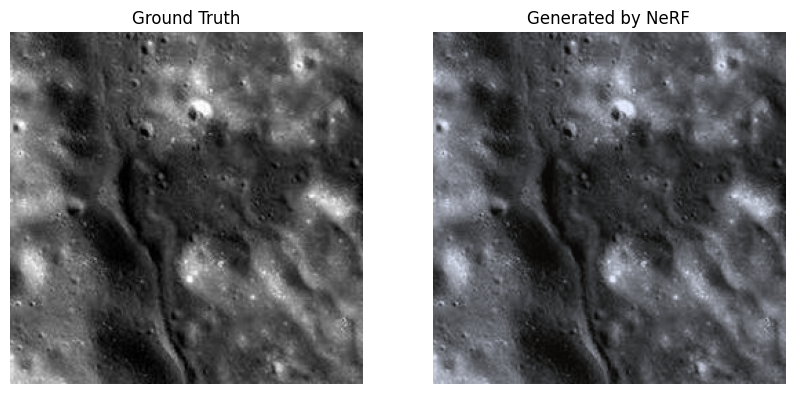

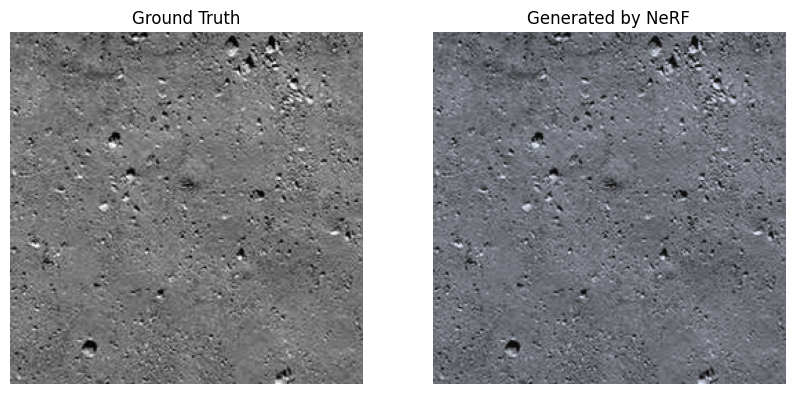

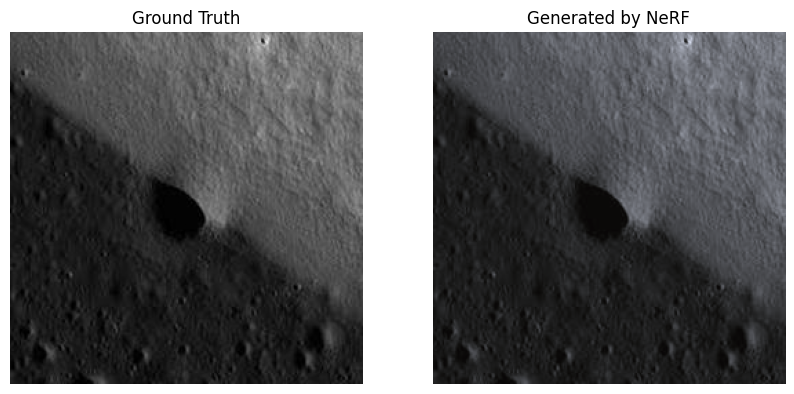

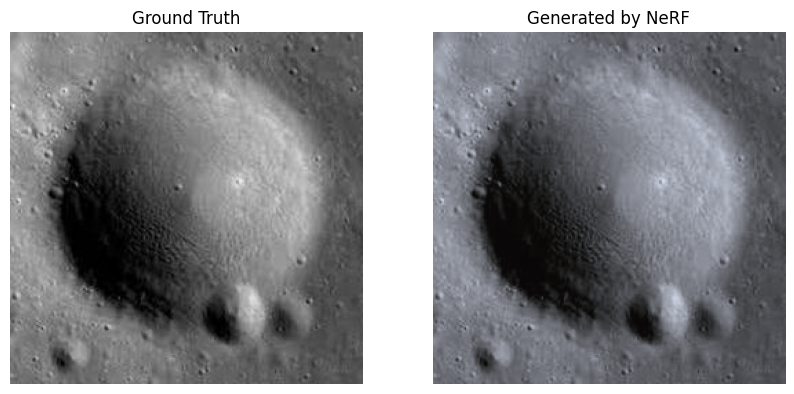

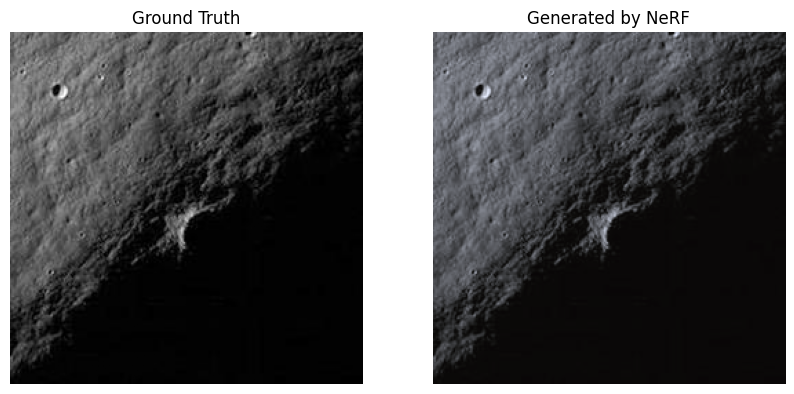

Mean Squared Error (MSE): 0.0005
Mean Absolute Error (MAE): 0.0173


In [66]:
mse = np.mean((predictions - x_test) ** 2)
mae = np.mean(np.abs(predictions - x_test))

num_examples = 5
random_indices = np.random.choice(len(x_test), size=num_examples, replace=False)

for idx in random_indices:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[idx])
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predictions[idx])
    plt.title('Generated by NeRF')
    plt.axis('off')

    plt.show()

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")